In [143]:
import pandas as pd
from scipy.spatial import KDTree
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pickle
from matplotlib import cm
from math import sin, cos, sqrt, atan2, radians
import matplotlib.dates as mdates
from statsmodels.stats.stattools import durbin_watson


# define all helper functions for the data

# function to define the hurricane score
def wind_speed(distance, v_m, r_m):

    b = 2
    x = 0
    s = 0.5
    x = ((r_m/distance)**b)*np.exp(1-(r_m/distance)**b)

    return v_m*x**s

# function to calculate distance using lat, lon (distance in km)
def distance(loc1, loc2):
    # Approximate radius of earth in km
    R = 6373.0

    lat1 = radians(loc1[0])
    lon1 = radians(loc1[1])
    lat2 = radians(loc2[0])
    lon2 = radians(loc2[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

# define set of functions to predict Rmax8
def calc_f(lat):
    return 2*.00007292*sin(radians(lat))

def calc_mratio(v_max, r_175, lat):
    return 0.699 * np.exp(-0.00618*(v_max - 17.5)-0.00210*(v_max - 17.5)*(1/2*calc_f(lat)*r_175))

def calc_m175(r_175, lat):
    return r_175 * 17.5 + 1/2 * calc_f(lat)*r_175**2

def calc_rmax(v_max, r_175, lat):
    return v_max/(calc_f(lat))*(sqrt(1+2*calc_f(lat)*(calc_m175(r_175, lat)*calc_mratio(v_max, r_175, lat))/(v_max**2))-1)


BD1: ['1', '7']
[1, 7]
[datetime.datetime(2017, 8, 17, 15, 0), datetime.datetime(2017, 8, 17, 21, 0), datetime.datetime(2017, 8, 18, 3, 0), datetime.datetime(2017, 8, 18, 9, 0), datetime.datetime(2017, 8, 18, 15, 0), datetime.datetime(2017, 8, 18, 21, 0), datetime.datetime(2017, 8, 19, 3, 0), datetime.datetime(2017, 8, 19, 9, 0), datetime.datetime(2017, 8, 19, 15, 0), datetime.datetime(2017, 8, 19, 21, 0), datetime.datetime(2017, 8, 20, 3, 0), datetime.datetime(2017, 8, 23, 15, 0), datetime.datetime(2017, 8, 23, 21, 0), datetime.datetime(2017, 8, 24, 3, 0), datetime.datetime(2017, 8, 24, 9, 0), datetime.datetime(2017, 8, 24, 15, 0), datetime.datetime(2017, 8, 24, 18, 0), datetime.datetime(2017, 8, 24, 21, 0), datetime.datetime(2017, 8, 25, 3, 0), datetime.datetime(2017, 8, 25, 9, 0), datetime.datetime(2017, 8, 25, 15, 0), datetime.datetime(2017, 8, 25, 21, 0), datetime.datetime(2017, 8, 26, 3, 0), datetime.datetime(2017, 8, 26, 9, 0), datetime.datetime(2017, 8, 26, 15, 0), datetime.dat

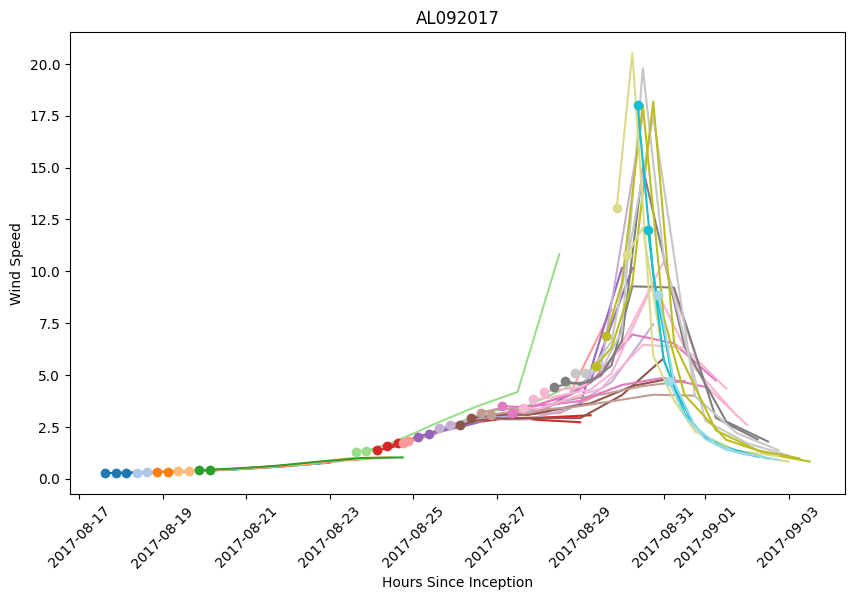

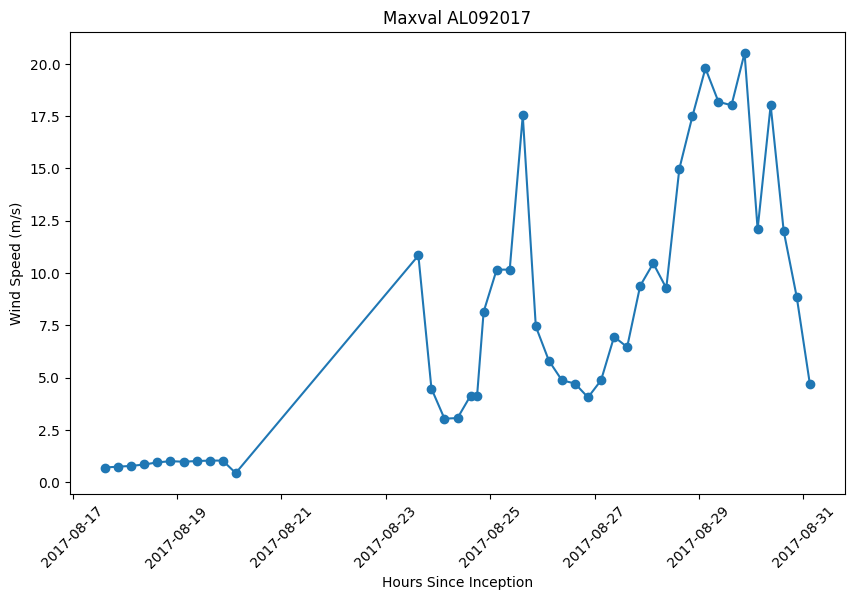

8
2017
2017-09-15 00:00:00


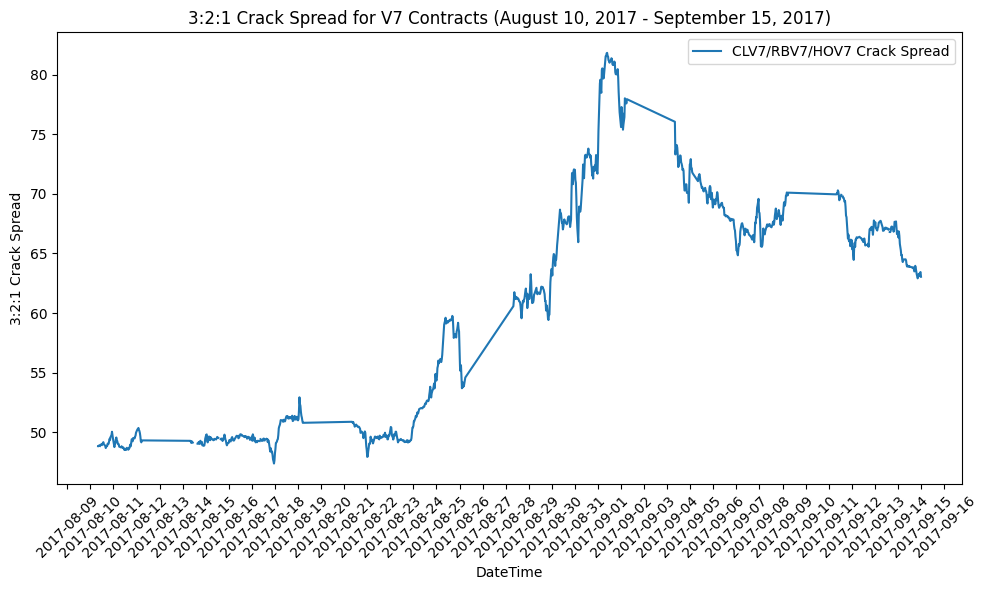

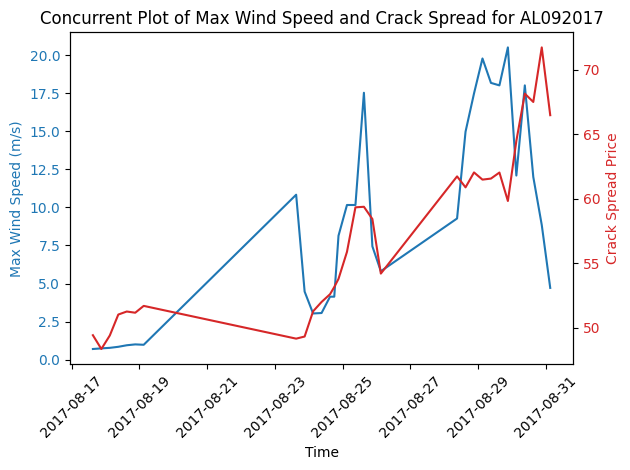

Durbin-Watson statistic for Immediate Crack Spread: 0.6061134391180428
OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:        321crack_spread   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     23.91
Date:                Sun, 07 Apr 2024   Prob (F-statistic):           3.45e-05
Time:                        00:17:23   Log-Likelihood:                -92.592
No. Observations:                  31   AIC:                             189.2
Df Residuals:                      29   BIC:                             192.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

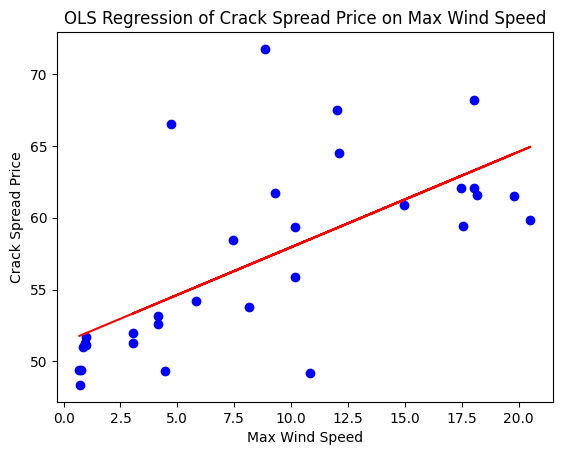

OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     23.91
Date:                Sun, 07 Apr 2024   Prob (F-statistic):           3.45e-05
Time:                        00:17:23   Log-Likelihood:                -92.592
No. Observations:                  31   AIC:                             189.2
Df Residuals:                      29   BIC:                             192.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.3128      1

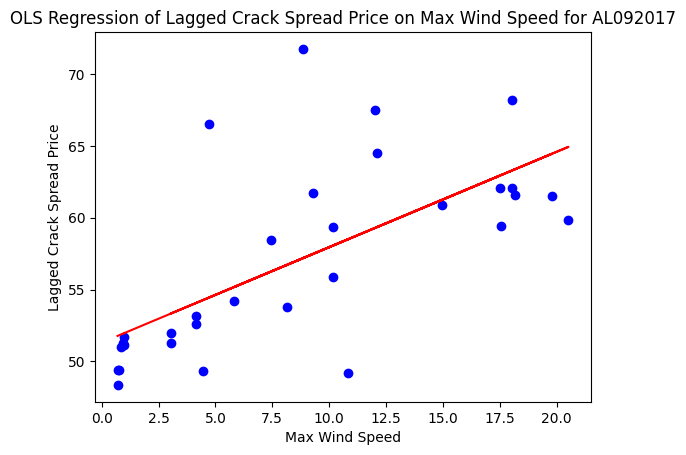

In [144]:
# storms = ['AL092017', 'AL142021', 'AL222020', 'AL132020', 'AL142020', 'AL032017'] # harvey, nicholas, beta, laura, marco, cindy
storms = ['AL092017'] # harvey
# storms = ['AL022019', 'AL032020', 'AL082020', 'AL192020', 'AL262020', 'AL282020'] # Hurricane Barry, Tropical Storm Cristobal, Hurricane Hanna, Hurricane Sally, Hurricane Delta, Hurricane Zeta
# storms = ['AL162017', 'AL092012', 'AL042012'] # Hurricane Nate, Hurricane Isaac, Tropical Storm Debby

houston = np.array([29.7604, -95.3698]) # define the lat lon values for houston
galveston = ([29.3013, -94.7977]) # define the lat lon values for galveston
port_arthur = ([29.8850, -93.9399]) # define lat long values for port arthur
baton_rouge = ([30.4515, -91.1871]) # define lat long values for baton rouge
pca = ([0.80449481, -0.52853266, -0.2710006])


def wind(storm, city):

    ## extract the month from financial data, since it is not stored in the track data
    file_path = f'Intraday_data/{storm}.csv'
    data = pd.read_csv(file_path)
    
    date_string = data.iloc[1]['date']
    parsed_date = datetime.strptime(date_string, "%Y-%m-%d")
    storm_month = parsed_date.month # the storm's initial month
    storm_day = parsed_date.day # the storm's initial day
    storm_year = int(storm[-4:])

    with open(f"Data/{storm_year}data.pkl", 'rb') as f:
        x = pickle.load(f)

    # Initialize storm inception time
    inception_time_str = x[storm]['1']['INIT']['Time (UTC)']
    inception_day = int(inception_time_str[:2])
    inception_hour = 0 # updated later
    inception_time = datetime(storm_year, storm_month, inception_day, inception_hour)

    # set up the figure for each storm
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.title(f"{storm}")
    plt.xlabel("Hours Since Inception")
    plt.ylabel("Wind Speed")

    day_count = 0
    prev28 = 0
    prev29 = 0
    prev30 = 0
    prev31 = 0
    base_day = list(x[storm]['1']['INIT']['Time (UTC)'])[0:2]
    print("BD1:", base_day)
    base_day = [int(base_day[0]), int(base_day[1])]
    print(base_day)
    max_harr = []
    t_release = []

    # iterate through each discussion (forecast)
    for i, key in enumerate(x[storm].keys()):
        times = [] # temporary until I have final formula for the threat score
        wind_speeds = []
        lat_arr = []
        lon_arr = []
        hscore_arr = []
        datetimes = []  # Store datetime objects
        max_hs = 0

        # iterate through each line in a discussion
        for j, key2 in enumerate(x[storm][key].keys()):
        
            # print(key, key2) # for debugging

            # only add if storm is not dissipated
            if (x[storm][key][key2]['Dissipated?'] != True):

                # extract lat/lon strings
                lat = x[storm][key][key2]['Latitude']
                lon = x[storm][key][key2]['Longitude']
                ws_temp = x[storm][key][key2]['Wind Speed (KT)']   
                
                time_string = list(x[storm][key][key2]['Time (UTC)'])

                current_day = [int(time_string[0]), int(time_string[1])]
                add31 = 0

                # check if the date ever crosses the month border, and if it does, then store what the previous day was
                if ((current_day[0] - base_day[0])*10 + (current_day[1] - base_day[1])) < 0:
                    if prev_day == [3,1]:
                        prev31 = 1
                    elif prev_day == [3,0]:
                        prev30 = 1
                    elif prev_day == [2,9]:
                        prev29 = 1
                    elif prev_day == [2,8]:
                        prev28 = 1
                    
                    # calculating the total number of hours past the initial date
                    adds = prev28 * 28 + prev29 * 29 + prev30 * 30 + prev31 * 31
                    day_hrs = ((current_day[0] - base_day[0])*10 + (current_day[1] - base_day[1]) + adds)* 24
                    hour = int(time_string[3]) * 10 + int(time_string[4]) + day_hrs
    
                    # Extract time and convert to datetime
                    current_datetime = inception_time + timedelta(hours=hour)
                    times.append(current_datetime)

                # if the date doesn't cross a month border, continue as usual
                else:
                    day_hrs = ((current_day[0] - base_day[0])*10 + (current_day[1] - base_day[1]))* 24
                    hour = int(time_string[3]) * 10 + int(time_string[4]) + day_hrs

                    # Extract time and convert to datetime
                    current_datetime = inception_time + timedelta(hours=hour)
                    times.append(current_datetime)
            
                # append the wind speed in knots to the wind speed array
                wind_speeds.append(int(ws_temp))

                # get the location of the storm
                if (lat[-1] == "N"):
                    lat_arr.append(float(lat[0:-1]))
                elif (lat[-1] == "S"):
                    lat_arr.append(-float(lat[0:-1]))
                if (lon[-1] == "E"):
                    lon_arr.append(float(lon[0:-1]))
                elif (lon[-1] == "W"):
                    lon_arr.append(-float(lon[0:-1]))

                # # define the storm that we are interested in analyzing [now defined in function]
                # city = port_arthur

                # calculate distance from city to the storm
                dist = distance(city, np.array([lat_arr[-1], lon_arr[-1]]))

                # convert to knots to m/s
                windspeed_ms = int(ws_temp) * 0.5144

                # append the wind speed in the city to the forecast's array, based on the equations of the wind field model from above
                hscore_arr.append(wind_speed(dist, windspeed_ms, calc_rmax(windspeed_ms, 60, lat_arr[-1])))

                # store the max wind speed in a given forecast
                if (hscore_arr[-1] > max_hs):
                    max_hs = hscore_arr[-1]

                # go to the next day
                prev_day = current_day
        
        # append the max wind speed after each forecast
        max_harr.append(max_hs)

        # append the initial release time for each forecast
        t_release.append(times[0])
    
        
        colormap = cm.tab20
        color = colormap(i / len(x[storm]))


        # plotting the forecasts
        ax.plot(times[0], hscore_arr[0], marker = "o", color = color)
        ax.plot(times, hscore_arr, color=color, label = key)    
        

    print(t_release)
    plt.xticks(rotation=45) 
    plt.show()

    
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    plt.title(f"Maxval {storm}")
    plt.xlabel("Hours Since Inception")
    plt.ylabel("Wind Speed (m/s)")
    ax2.plot(t_release, max_harr, marker = "o")

    # Rotate x-axis labels
    plt.xticks(rotation=45)

    plt.show()

    return t_release, max_harr

def crack(storm):

    file_path = f'Intraday_data/{storm}.csv'
    data = pd.read_csv(file_path)

    # Beginning of the Data
    date_string = data.iloc[1]['date']
    parsed_date = datetime.strptime(date_string, "%Y-%m-%d")
    storm_month = parsed_date.month # the storm's initial month
    storm_day = parsed_date.day # the storm's initial day
    storm_year = int(storm[-4:])
    print(storm_month)
    print(storm_year)

    # Convert date and time to a datetime format
    data['datetime'] = pd.to_datetime(data['date']) + timedelta(hours=13.5) + pd.to_timedelta(data['time'], unit='min') 

    # Convert HO and RB prices to per barrel
    data.loc[data['sym'].str.contains('HO') | data['sym'].str.contains('RB'), ['bid', 'ask', 'prc']] *= 42

    contract = data.iloc[-1]['sym'][2:]


    if (storm == 'AL132020') | (storm == 'AL142020'):
        contract = 'V0'

    if storm == 'AL032017':
        contract = 'Q7'

    if storm == 'AL022019':
        contract = 'N9'

    if (storm == 'AL032020'):
        contract = 'N0'
    if (storm == 'AL082020'):
        contract = 'Q0'

    if (storm == 'AL192020'):
        contract = 'V0'

    if (storm == 'AL262020'):
        contract = 'X0'
        
    if (storm == 'AL282020'):
        contract = 'Z0'

    if (storm == 'AL162017'):
        contract = 'X7'

    if (storm == 'AL092012'):
        contract = 'V2'
        
    if (storm == 'AL042012'):
        contract = 'Q2'
 
 
    ho = f'HO{contract}'
    rb = f'RB{contract}'
    cl = f'CL{contract}'

    
    date_final = data.iloc[-1]['date']
    parsed_date_final = datetime.strptime(date_final, "%Y-%m-%d")
    print(parsed_date_final)
    final_month = parsed_date_final.month # the storm's initial month
    final_day = parsed_date_final.day # the storm's initial day
    final_year = parsed_date_final.year

    storm_year = int(storm[-4:])

    
    # Filter data for the desired date range and specific contracts
    start_date = datetime(storm_year, storm_month, storm_day)
    end_date = datetime(final_year,final_month, final_day)
    filtered_data = data[(data['datetime'] >= start_date) & (data['datetime'] <= end_date)]
    filtered_data = filtered_data[filtered_data['sym'].isin([cl, rb, ho])]
        

    # Pivot the data for easier calculation
    pivoted_data = filtered_data.pivot_table(index='datetime', columns='sym', values='prc')

    # Calculate the 3:2:1 crack spreads
    pivoted_data['321crack_spread'] = -1* ( 3 * pivoted_data[cl] - 2 * pivoted_data[rb] - pivoted_data[ho])

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(pivoted_data.index, pivoted_data['321crack_spread'], label=f'{cl}/{rb}/{ho} Crack Spread')

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.xticks(rotation=45)
    plt.xlabel('DateTime')
    plt.ylabel('3:2:1 Crack Spread')
    plt.title(f'3:2:1 Crack Spread for {contract} Contracts ({start_date.strftime("%B %d, %Y")} - {end_date.strftime("%B %d, %Y")})')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return pivoted_data

time_difference_threshold = 31  # 30 minutes, for example

# iterate through each storm in the 'storms' list above. This will be the loop that sets up the X and Y data for the regression
for storm in storms:

    t_release, max_harr = wind(storm, port_arthur) ################################################################################ define city
    
    # Phase 2: Processing the Crack Spread Data
    
    pivoted_data = crack(storm)

    # Phase 3: Plotting

    # Convert t_release to pandas datetime for better plotting and aligning
    t_release_datetime = pd.to_datetime(t_release)

    # Convert pivoted_data index to the same format as t_release for KDTree
    pivoted_data_seconds = pivoted_data.index.map(lambda x: x.timestamp())
    t_release_seconds = t_release_datetime.map(lambda x: x.timestamp()).values.reshape(-1, 1)

    # Create KDTree and find the nearest dates in pivoted_data for each date in t_release
    tree = KDTree(pivoted_data_seconds.values.reshape(-1, 1))
    distances, indices = tree.query(t_release_seconds)

    # Filter out indices where the distance is more than the threshold
    valid_indices = distances < time_difference_threshold
    aligned_t_release = t_release_datetime[valid_indices]
    aligned_max_harr = np.array(max_harr)[valid_indices]

    # Align crack spread values with filtered t_release dates
    aligned_crack_spreads = pivoted_data['321crack_spread'].iloc[indices][valid_indices].values

    # Create the figure and the first axis for max wind speed
    fig, ax1 = plt.subplots()

    # Max Wind Speed plot (ax1)
    color = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Max Wind Speed (m/s)', color=color)
    ax1.plot(aligned_t_release, aligned_max_harr, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Setting up the x-axis for dates
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)

    # Create the second axis for crack spread
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    # Crack Spread plot (ax2)
    color = 'tab:red'
    ax2.set_ylabel('Crack Spread Price', color=color)
    ax2.plot(aligned_t_release, aligned_crack_spreads, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    

    # Title and layout
    plt.title(f'Concurrent Plot of Max Wind Speed and Crack Spread for {storm}')
    fig.tight_layout()
    plt.show()


    # Phase 4: Regression


    # Assuming 't_release' contains the timestamps and 'max_harr' contains the wind speeds
    wind_speed_data = pd.DataFrame({
        'datetime': pd.Series(t_release),
        'max_harr': max_harr
    })

    # Filter out rows where max_harr is below a threshold [ do not need anymore ]
    filtered_wind_speed_data = wind_speed_data[wind_speed_data['max_harr'] >= 0]

    # Convert the timestamps in filtered_wind_speed_data and pivoted_data to a common format (seconds since the Unix epoch)
    time_format = lambda x: (x - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    filtered_wind_speed_data['datetime'] = filtered_wind_speed_data['datetime'].apply(time_format)

    # Prepare the crack spread data
    pivoted_data_reset = pivoted_data.reset_index()
    pivoted_data_seconds = pd.DataFrame({
        'datetime': pivoted_data_reset['datetime'].map(time_format),
        '321crack_spread': pivoted_data_reset['321crack_spread']
    })

    # Merge based on the exact timestamp match
    merged_data = pd.merge(filtered_wind_speed_data,
                        pivoted_data_seconds,
                        on='datetime',
                        how='inner')

    # The result is a DataFrame with aligned wind speed and crack spread data
    aligned_wind_speed = merged_data['max_harr']
    aligned_crack_spread = merged_data['321crack_spread']


    # Extracting the aligned wind speed data
    aligned_max_harr = merged_data['max_harr'].values


    # Reshape aligned wind speed data for regression analysis
    X = aligned_max_harr.reshape(-1, 1)
    y = aligned_crack_spread

    # Adding a constant to the model for the intercept
    X_with_constant = sm.add_constant(X)

    # Building the OLS model
    ols_model = sm.OLS(y, X_with_constant)

    # Fitting the OLS model
    ols_results = ols_model.fit()

    # Calculate the Durbin-Watson statistic
    dw_statistic = durbin_watson(ols_results.resid)

    # Print the Durbin-Watson statistic
    print(f"Durbin-Watson statistic for Immediate Crack Spread: {dw_statistic}")

    # Printing the summary statistics
    print("OLS Regression Results:")
    print(ols_results.summary())

    # Plotting the results
    plt.scatter(X, y, color='blue')
    plt.plot(X, ols_results.predict(X_with_constant), color='red')
    plt.xlabel('Max Wind Speed')
    plt.ylabel('Crack Spread Price')
    plt.title('OLS Regression of Crack Spread Price on Max Wind Speed')
    plt.show()




    # Experiment: Lagged OLS

    # Define the lag in minutes
    lag_minutes = 0  # For example, a 30-minute lag
    pivoted_data.index = pd.to_datetime(pivoted_data.index)
    # Shift the crack spread data by the specified lag
    pivoted_data['lagged_crack_spread'] = pivoted_data['321crack_spread'].shift(periods=-lag_minutes, freq='T')

    # Convert t_release to pandas datetime for better plotting and aligning
    t_release_datetime = pd.to_datetime(t_release)

    # Convert pivoted_data index to the same format as t_release for KDTree
    pivoted_data_seconds = pivoted_data.index.map(lambda x: x.timestamp())
    t_release_seconds = t_release_datetime.map(lambda x: x.timestamp()).values.reshape(-1, 1)

    # Create KDTree and find the nearest dates in pivoted_data for each date in t_release
    tree = KDTree(pivoted_data_seconds.values.reshape(-1, 1))
    distances, indices = tree.query(t_release_seconds)

    # Filter out indices where the distance is more than the threshold
    valid_indices = distances < time_difference_threshold
    aligned_t_release = t_release_datetime[valid_indices]

    # Align lagged crack spread values with the filtered t_release dates
    aligned_lagged_crack_spreads = pivoted_data['lagged_crack_spread'].iloc[indices][valid_indices].values


    # Align lagged crack spread values with the filtered t_release dates
    aligned_lagged_crack_spreads = pivoted_data['lagged_crack_spread'].iloc[indices][valid_indices].values

    # Ensure that we drop NaN values which might have been introduced by the shift
    mask = ~np.isnan(aligned_lagged_crack_spreads)
    final_aligned_max_harr = aligned_max_harr[mask]
    final_aligned_lagged_crack_spreads = aligned_lagged_crack_spreads[mask]

    # Prepare the data for regression
    X = final_aligned_max_harr.reshape(-1, 1)
    y = final_aligned_lagged_crack_spreads

    # Add a constant to the model for the intercept
    X_with_constant = sm.add_constant(X)

    # Build and fit the OLS model
    ols_model = sm.OLS(y, X_with_constant)
    ols_results = ols_model.fit()

    # Print the summary statistics
    # print("OLS Regression Results with Lagged Crack Spread:")
    print("OLS Regression Results:")

    print(ols_results.summary())

    # Plotting the results
    plt.scatter(X, y, color='blue')
    plt.plot(X, ols_results.predict(X_with_constant), color='red')
    plt.xlabel('Max Wind Speed')
    plt.ylabel('Lagged Crack Spread Price')
    plt.title(f'OLS Regression of Lagged Crack Spread Price on Max Wind Speed for {storm}')
    plt.show()



        


